# Introduction

Neural signals, like the example shown below, are analyzed in order to extract information about brain activity. Basically, we process these signals in order to extract features that will hopefully correlate with a behavior, pathology, or something else.

As the most prominent feature of these signals tends to be the oscillations in them, spectral analysis is often applied in order to characterize these rhythms in terms of their frequency, power, and phase.

The conventional approach to analyzing these properties as a function of time is to only study a narrowband signal by applying a wavelet transform or bandpass filtering followed by the Hilbert transform. The latter is demonstrated below.

# Conventional analysis of amplitude and phase

### Analysis using the Hilbert transform

Text(0,0.5,'Phase (radians)')

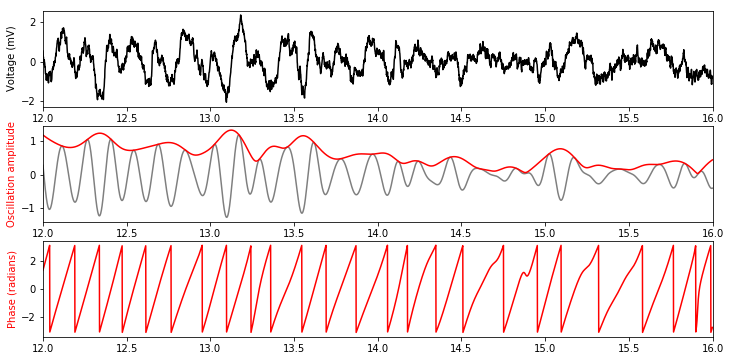

In [16]:
import numpy as np
import scipy as sp
from scipy import signal as spsignal
import matplotlib.pyplot as plt
from bycycle.filt import amp_by_time, phase_by_time, bandpass_filter
from bycycle.sim import sim_noisy_bursty_oscillator
%matplotlib inline

# Load neural signal
cf = 7
f_theta = (4,10)
T = 100
Fs = 1000
np.random.seed(0)
signal = sim_noisy_bursty_oscillator(cf, T, Fs, prob_enter_burst=.1,
                                     prob_leave_burst=.1, SNR=2,
                                     rdsym=.3)
N_seconds_filter = .75

# Compute amplitude and phase
signal_filt = bandpass_filter(signal, Fs, f_theta, N_seconds=N_seconds_filter)
theta_amp = amp_by_time(signal, Fs, f_theta,
                        filter_kwargs={'N_seconds': N_seconds_filter})
theta_phase = phase_by_time(signal, Fs, f_theta,
                            filter_kwargs={'N_seconds': N_seconds_filter})

# Plots signal
t = np.arange(0, len(signal)/Fs, 1/Fs)
tlim = (12, 16)
tidx = np.logical_and(t>=tlim[0], t<tlim[1])

plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(t[tidx], signal[tidx], 'k')
plt.xlim(tlim)
plt.ylabel('Voltage (mV)')

plt.subplot(3,1,2)
plt.plot(t[tidx], signal_filt[tidx], 'k', alpha=.5)
plt.plot(t[tidx], theta_amp[tidx], 'r')
plt.xlim(tlim)
plt.ylabel('Oscillation amplitude', color='r')

plt.subplot(3,1,3)
plt.plot(t[tidx], theta_phase[tidx], 'r')
plt.xlim(tlim)
plt.ylabel('Phase (radians)', color='r')

This conventional analysis has some advantages and disadvantages. As for advantages:
- Quick calculation
- Neat mathematical theory
- Results *largely* make sense
- Defined at every point in time.

Because of this last property, these traces have come to be known as "instantaneous amplitude" and "instantaneous phase." And they seem to make a lot of sense, when looking at the raw signal.

However, there are some key disadvantages to this analysis that stem from its sine wave basis.

1. Being defined at every point in time gives the illusion that the phase and amplitude estimates are valid at all points in time. However, the amplitude and phase estimates are pretty garbage when there's no oscillation going on (the latter half of the time series above). The "amplitude" and "phase" values are meaningless when no oscillation is actually present. Rather, they are influenced by the other aspects of the signal, such as transients. For this reason, these measures are flaws, and **burst detection** is very important to help alleviate this issue.

2. This analysis does not capture a potentially important aspect of the data, in that the oscillatory cycles tend to have short rises and longer decays. This is partly because the signal is filtered in a narrow frequency band (using a sine wave basis) that cannot accurately reconstruct nonsinusoidal waveforms. Furthermore, this nonsinusoidal feature will unintuitively bias amplitude and phase estimates (though perhaps negligibly). Furthermore, there are no apparent tools for extracting nonsinusoidal properties using conventional techniques.

### Note that different hyperparameter choices for filters can lead to significant differences in results
When effect sizes are small, these hyperparameter choices may make a crucial difference.

(12, 16)

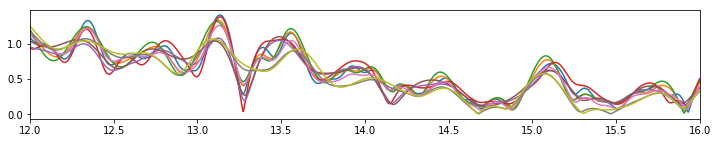

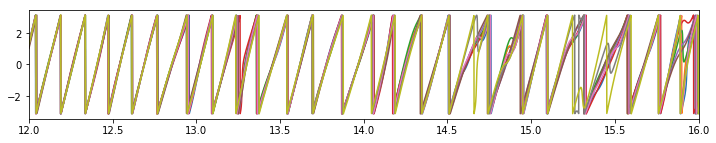

In [28]:
# Different hyperparameter choices - filter length and center frequency and bandwidth
f_thetas = [(4, 10), (4, 8), (5,9)]
N_secondss = [.4, .75, 1.2]

amps = []
phases = []
for f_theta in f_thetas:
    for N_seconds_filter in N_secondss:
        amp = amp_by_time(signal, Fs, f_theta,
                          filter_kwargs={'N_seconds': N_seconds_filter})
        phase = phase_by_time(signal, Fs, f_theta,
                              filter_kwargs={'N_seconds': N_seconds_filter})
        amps.append(amp)
        phases.append(phase)
        
plt.figure(figsize=(12,2))
for amp in amps:
    plt.plot(t[tidx], amp[tidx])
plt.xlim(tlim)

plt.figure(figsize=(12,2))
for phase in phases:
    plt.plot(t[tidx], phase[tidx])
plt.xlim(tlim)

# Cycle-by-cycle approach
The main issues in the conventional approach are because the measurements of amplitude and phase are very indirect, using certain transforms in the frequency domain defined by sine waves. Therefore, we developed an alternative approach that analyzes oscillatory properties more directly by staying in the time domain. Arguably, it is best to analyze these signals in the time domain because this is the domain in which they are generated (the brain does not generate sums of independent sine waves).

The benefits of this alternative approach may include:
1. More direct measurements of amplitude and frequency may be more accurate ([see Figures 5 and 6 in the associated preprint](https://www.biorxiv.org/content/early/2018/04/16/302000)).
2. Characterization of waveform shape, in addition to amplitude and phase and frequency.
3. Explicit definitions of which portions of the signal are suitable for analysis (in oscillatory bursts) or not (no oscillation present).

It is important to note that this approach also has some key disadvantages. First, it is not widely adopted like the conventional techniques. Second, it requires more hyperparameter choosing and potentialyy more quality control compared to conventional techniques. I emphasize how important it is to visualize the cycle-by-cycle characterization and burst detection to assure that the metrics match the intuition. However, this is not commonly expected or performed using conventional techniques.

### See the next notebook on the cycle-by-cycle algorithm